# Libraries

In [1]:
#Import appropriate libraries
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import shap
from sklearn import linear_model
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression

from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import PartialDependenceDisplay
import pipreqsnb

# Data Analysis

In [2]:
#Load data
df = pd.read_csv('kc_house_data.csv')
df.describe()


,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [3]:
#EDA 
#Change sqrt_basement and yr_renovated to dummy variables
df.loc[df['sqft_basement']>0, 'sqft_basement'] = 1
df.loc[df['yr_renovated']>0, 'yr_renovated'] = 1

#Create age column to be 2015 minus the year the house was built
df['age'] = 2015 - df['yr_built']

#Remove unncessary or irrelevant data
df.drop(['id','date','zipcode','yr_built'], axis=1, inplace = True)


# Model Fitting (Random Forest Regression)

In [4]:
#Training and Test Set Dataset Split
x = df.iloc[:, 1:18]
y = df.iloc[:, 0]
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state= 0)



In [5]:
#Train the random forest regression model
rf = RandomForestRegressor(n_estimators=100, random_state= 0, max_depth = 10)
rf.fit(x_train, y_train)
print("R^2 for training set: ",rf.score(x_train,y_train))
print("R^2 for test set: ", rf.score(x_test,y_test))

R^2 for training set:  0.9351923825251257
R^2 for test set:  0.8776674314928562


# Interpretability Techniques

## Feature Importance Plots

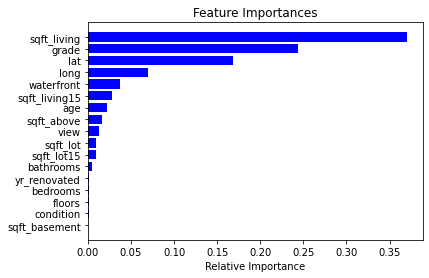

In [6]:
features=df.columns[[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]]
importances = rf.feature_importances_ #Get feature importances from the random forest
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## Partial Depedence Plots / Individual Conditional Expectation

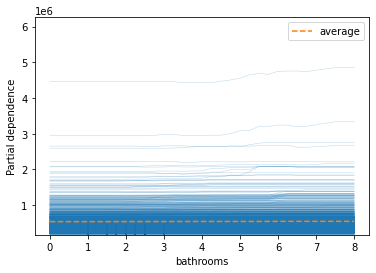

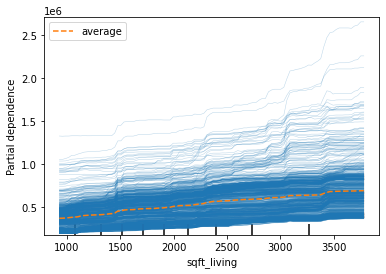

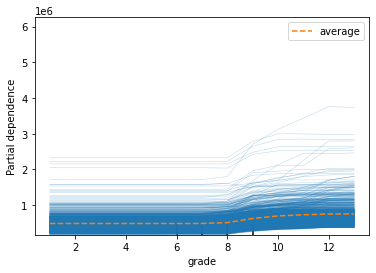

In [8]:
#Plot PDP and ICE plots together for 3 features 
PartialDependenceDisplay.from_estimator(rf,x_train,features = [1],kind='both',pd_line_kw={"color": "tab:orange","linestyle": "--"})
PartialDependenceDisplay.from_estimator(rf,x_train,features = [2],kind='both',pd_line_kw={"color": "tab:orange","linestyle": "--"})
PartialDependenceDisplay.from_estimator(rf,x_train,features = [8],kind='both',pd_line_kw={"color": "tab:orange","linestyle": "--"})


## Global Surrogate

In [9]:
y_pred = rf.predict(x_train) #Get predictions of the training set using the random forest model

x_vars =['sqft_living','grade','lat','long','age']
x_train_lin = x_train[x_vars] #Select specific variables from the training set

#Fit a linear regression model using the random forest predictions and training data
linreg = linear_model.LinearRegression() 
linreg.fit(x_train_lin,y_pred)

y_pred_lr = linreg.predict(x_train_lin)
print("The R^2 value of the surrogate model is:",linreg.score(x_train_lin,y_pred))

#Display coefficients of linear regression model
d = {'variables': x_vars, 'coefficient': linreg.coef_}
coef_df = pd.DataFrame(d)
coef_df

The R^2 value of the surrogate model is: 0.7282753741055636


,variables,coefficient
0,sqft_living,198.346841
1,grade,106311.328614
2,lat,536795.166547
3,long,-141945.774890
4,age,2518.591039


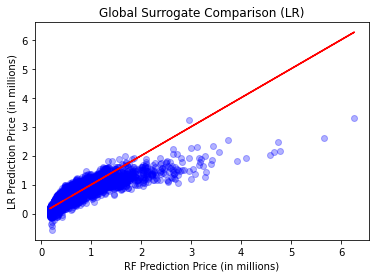

In [10]:
#Plot linear regression prediction against random forest prediction
plt.scatter(y_pred/1000000,y_pred_lr/1000000, color = 'b',alpha=0.3)
plt.plot(y_pred/1000000,y_pred/1000000,color='red')
plt.xlabel('RF Prediction Price (in millions)')
plt.ylabel('LR Prediction Price (in millions)')
plt.title('Global Surrogate Comparison (LR)')

plt.show()

## Shapley Values

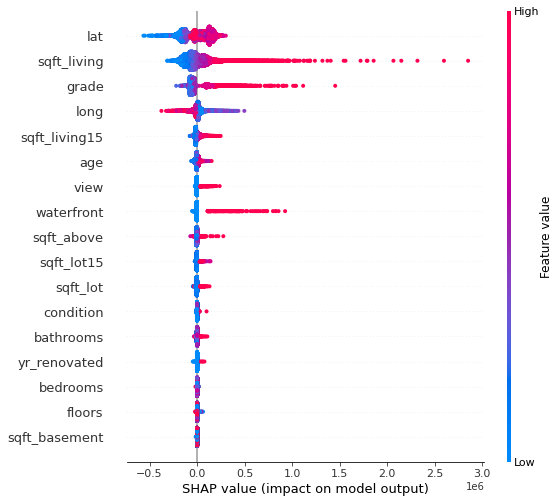

In [11]:
#Plot shapley values for all features
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(x_train)
shap.summary_plot(shap_values, features=x_train, feature_names = ["bedrooms","bathrooms","sqft_living","sqft_lot","floors",
                                                                  "waterfront","view", "condition","grade","sqft_above",
                                                                  "sqft_basement","yr_renovated","lat","long","sqft_living15",
                                                                  "sqft_lot15","age"])
